# LsqFit.jl

https://github.com/JuliaNLSolvers/LsqFit.jl

# Summary

LsqFit.jl is a packages that provides basic least square fitting in Julia. It provides two main methods, curve_fit() and estimate_errors() which both work well. At the moment it only uses  the Levenberg-Marquardt algorithm for non-linear fitting.


# Details

| Test        | Results       |    
| ------------|:-------------:|
| Package work| Yes |
| Deprecations warnings      | No     |
| Compatible with JuliaDB | Yes |
| Contains documentation | No, but examples |
| Simplicity | good |

# Functions

functionality as listed in Github repository

`fit = curve_fit(model, [jacobian], x, y, [w,] p0; kwargs...)`:

* `model`: function that takes two arguments (x, params)
* `jacobian`: (optional) function that returns the Jacobian matrix of `model`
* `x`: the independent variable
* `y`: the dependent variable that constrains `model`
* `w`: (optional) weight applied to the residual; can be a vector (of `length(x)` size or empty) or matrix (inverse covariance matrix)
* `p0`: initial guess of the model parameters
* `kwargs`: tuning parameters for fitting, passed to `levenberg_marquardt`, such as `maxIter` or `show_trace`
* `fit`: composite type of results (`LsqFitResult`)

`sigma = estimate_errors(fit, alpha=0.95; atol, rtol)`:

* `fit`: result of curve_fit (a `LsqFitResult` type)
* `alpha`: confidence limit to calculate for the errors on parameters
* `atol`: absolute tolerance for negativity check
* `rtol`: relative tolerance for negativity check


`covar = estimate_covar(fit)`:

* `fit`: result of curve_fit (a `LsqFitResult` type)
* `covar`: parameter covariance matrix calculated from the jacobian of the model at the fit point, using the weights (if specified) as the inverse covariance of observations

# Example code

Based on Github example

In [34]:
using LsqFit

# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
model(x, p) = p[1]*exp.(-x.*p[2])

# some example data
# xdata: independent variables
# ydata: dependent variable
xdata = linspace(0,10,20)
ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))
p0 = [0.5, 0.5]

fit = curve_fit(model, xdata, ydata, p0)
# fit is a composite type (LsqFitResult), with some interesting values:
#	fit.dof: degrees of freedom
#	fit.param: best fit parameters
#	fit.resid: residuals = vector of residuals
#	fit.jacobian: estimated Jacobian at solution

# We can estimate errors on the fit parameters,
# to get 95% confidence error bars:
errors = estimate_errors(fit, 0.95)

# The finite difference method is used above to approximate the Jacobian.
# Alternatively, a function which calculates it exactly can be supplied instead.
function jacobian_model(x,p)
    J = Array{Float64}(length(x),length(p))
    J[:,1] = exp.(-x.*p[2])    #dmodel/dp[1]
    J[:,2] = -x.*p[1].*J[:,1]  #dmodel/dp[2]
    J
end
fit = curve_fit(model, jacobian_model, xdata, ydata, p0);


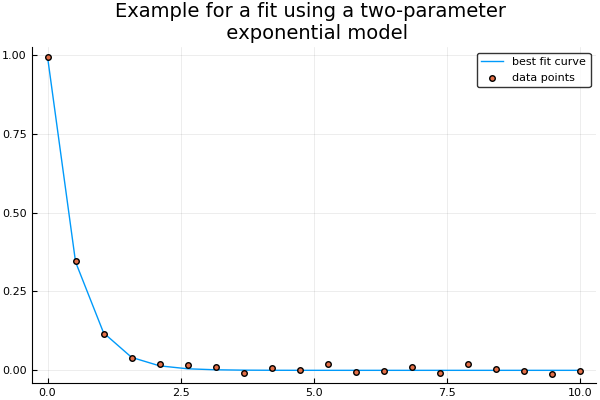

In [37]:
using Plots
plot(xdata, model(xdata,fit.param),label = "best fit curve")
scatter!(xdata,ydata,label ="data points",title = "Example for a fit using a two-parameter \n exponential model")

# Example Usage with Julia DB

In [17]:
include("load_titanic.jl")

load (generic function with 2 methods)

In [20]:
train, train_targets, test, test_targets = load(true)  #load as JuliaDB tables

Metadata for 0 / 1 files can be loaded from cache.
Reading 1 csv files totalling 58.201 KiB in 1 batches...


(Table with 634 rows, 8 columns:
PassengerId  Pclass  Sex  Age   SibSp  Parch  Fare     Embarked
───────────────────────────────────────────────────────────────
1            3       1    22.0  1      0      7.25     0
2            1       0    38.0  1      0      71.2833  1
3            3       0    26.0  0      0      7.925    0
4            1       0    35.0  1      0      53.1     0
7            1       1    54.0  0      0      51.8625  0
8            3       1    2.0   3      1      21.075   0
9            3       0    27.0  0      2      11.1333  0
10           2       0    14.0  1      0      30.0708  1
11           3       0    4.0   1      1      16.7     0
12           1       0    58.0  0      0      26.55    0
13           3       1    20.0  0      0      8.05     0
15           3       0    14.0  0      0      7.8542   0
⋮
877          3       1    20.0  0      0      9.8458   0
878          3       1    19.0  0      0      7.8958   0
880          1       0    56.0  0      

To check compatibility, we want to fit a curve to some random subset of the data. Pick the first 20 instances of passenger ID and Age. Get xdata = passengerID, ydata=Age.

In [32]:
ID=select(train[1:20], 1);
Age = select(train[1:20],4);

In [42]:
model(x, p) = p[1]*x.^5+p[2]*x.^4+p[3]*x.^3+p[4]*x.^2+p[5]*x+p[6]
p0 = ones(6)
fit = curve_fit(model, ID, Age,p0);


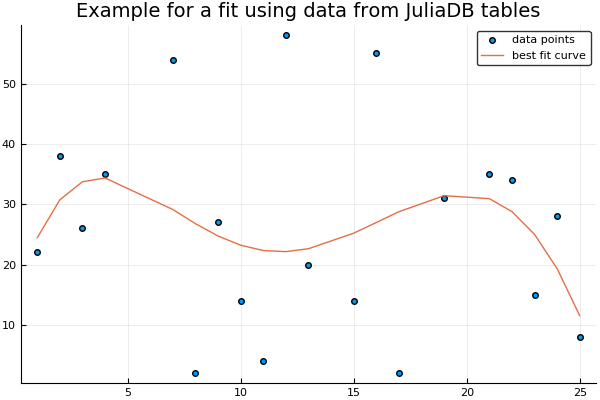

In [43]:
scatter(ID,Age,label ="data points",title = "Example for a fit using data from JuliaDB tables")
plot!(ID, model(ID,fit.param),label = "best fit curve")

# Simple Benchmarking against Python

We fit the same function to the same data set (up to noise) once using LsqFit and once using scipy.optimize.curve_fit and compare the running time.

In [80]:
model(x,p) = p[1] * exp.(-p[2] * x) + p[3];
xdata = linspace(0, 4, 50)
ydata = model(xdata, [2.5, 1.3, 0.5])
srand(1729)
y_noise = 0.2 * rand(50)
ydata = ydata+y_noise
p0 = ones(3)

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

In [83]:
@elapsed( curve_fit(model, xdata, ydata,p0))

0.00016819

|      | Python       | Julia       |
| ------------|:-------------:|-----------|
|Time | 0.0030889511108398438 | 0.00016819 |

The Julia version was faster in this case. This might change for running bigger jobs. Also in Python for lots of models the function and starting parameters don't have to be specified, the programme automatically fits the best function to the data. The package here doesn't have this functionality (yet!).